In [3]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin




In [6]:
# import Data
iris = datasets.load_iris()
wine = datasets.load_wine()
breast_cancer = datasets.load_breast_cancer()
houses = datasets.load_boston()

In [24]:
# Functions - https://github.com/fboldt/aulasml/blob/master/arvore.ipynb

def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

def impurezaValor(x, y, valor):
    iguais = x==valor
    impurezaIguais = impureza(y[iguais])
    propIguais = sum(iguais)/len(y)
    impurezaDiferentes = impureza(y[~iguais])
    propDiferentes = sum(~iguais)/len(y)
    impurezaTotal = propIguais*impurezaIguais + propDiferentes*impurezaDiferentes
    return impurezaTotal

def impurezaMinima(X, y):
    impurezas = []
    caracteristicasValores = []
    for i in range(X.shape[1]):
        valores = sorted(list(set(X[:,i])))
        for valor in valores:
            caracteristicasValores.append([i,valor])
            impurezasValorCaracteristica = impurezaValor(X[:,i], y, valor)
            impurezas.append(impurezasValorCaracteristica)
    caracteristicasValores = np.array(caracteristicasValores)
    impurezas = np.array(impurezas)
    menorimpureza = np.argmin(impurezas)
    caracteristica, valor = caracteristicasValores[menorimpureza]
    return impurezas[menorimpureza], int(caracteristica), valor

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.caracteristica = 0
    def fit(self, X, y):
        self.valor = np.mean(X[:,self.caracteristica])
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y
    
def plotdecisao(modelo, X, y, data):
    modelo.fit(X, y)
    X0s = np.linspace(np.min(X[:, 0])-0.2, np.max(X[:, 0])+0.2, 100)
    X1s = np.linspace(np.min(X[:, 1])-0.2, np.max(X[:, 1])+0.2, 100)
    x0, x1 = np.meshgrid(X0s, X1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], 
                 X[:,1][y==k], 
                 'o') 
                 #label=f'{data.target_names[k]} - [{k}]')
    plt.xlabel(f'X[0]: {data.feature_names[pair[0]]}')
    plt.ylabel(f'X[1]: {data.feature_names[pair[1]]}')
    plt.show()

'''
Crie a sua heurística para escolher a melhor característica 
para um nó de uma árvore de decisão e compare com a implementação 
feita nos vídeos postados nesse tópico aqui no AVA e com a 
implementação do scikit learn.
'''
# Dados para construcao do modelo para explorar diferentes heuristicas.
criterion = ['gini', 'entropy']
splitter = ['best','random']
max_features = ['auto','sqrt', 'log2']
parametros = dict(criterion=criterion,
                 splitter=splitter,
                 max_features=max_features)
modelo = GridSearchCV(DecisionTreeClassifier(), parametros)

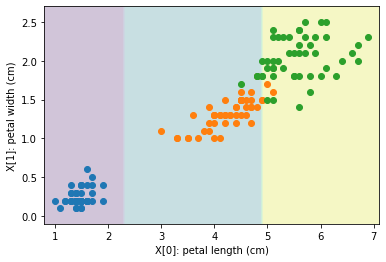

In [21]:
# Exemplo dos videos
pair = [2,3]
X, y = iris.data[:,pair], iris.target
plotdecisao(Arvore(), X, y, iris)

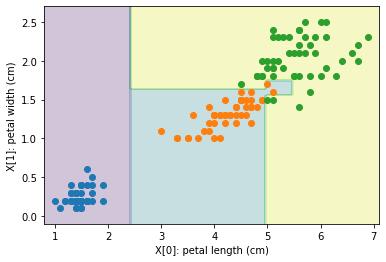

In [23]:
# Exemplo SkLearn Padrao
plotdecisao(DecisionTreeClassifier(), X, y, iris)

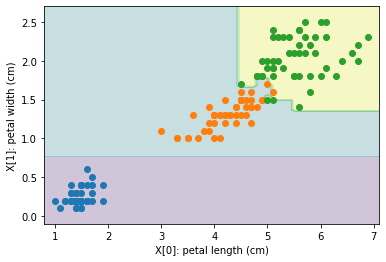

In [25]:
# Exemplo SkLearn Padrao
plotdecisao(modelo, X, y, iris)

Melhor Criterion: gini
Melhor Splitter: best
Melhor Max Features: log2
Validação Cruzada: [0.73333333 0.63333333 0.73333333 0.76666667 0.6       ]
Score Médio:69.33 %


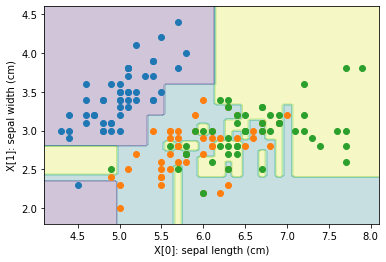

Melhor Criterion: gini
Melhor Splitter: random
Melhor Max Features: log2
Validação Cruzada: [0.9        0.86666667 0.9        0.9        0.96666667]
Score Médio:90.67 %


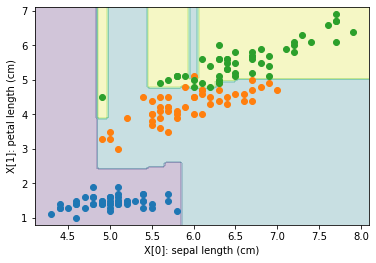

Melhor Criterion: entropy
Melhor Splitter: random
Melhor Max Features: sqrt
Validação Cruzada: [0.83333333 0.93333333 0.83333333 0.9        0.96666667]
Score Médio:89.33 %


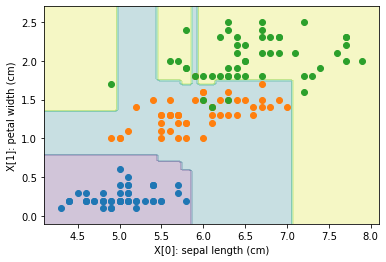

Melhor Criterion: gini
Melhor Splitter: best
Melhor Max Features: auto
Validação Cruzada: [0.86666667 0.96666667 0.9        0.9        0.96666667]
Score Médio:92.00 %


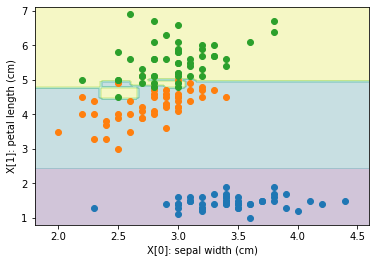

Melhor Criterion: gini
Melhor Splitter: best
Melhor Max Features: sqrt
Validação Cruzada: [0.93333333 0.96666667 0.9        0.86666667 0.93333333]
Score Médio:92.00 %


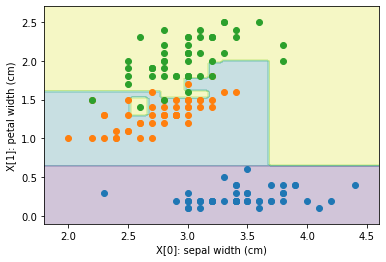

Melhor Criterion: gini
Melhor Splitter: random
Melhor Max Features: sqrt
Validação Cruzada: [0.96666667 0.96666667 0.9        0.93333333 1.        ]
Score Médio:95.33 %


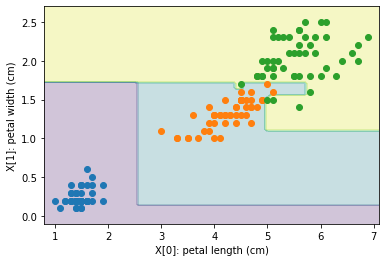

In [26]:

'''
Faça comparações plotando as regiões de decisão com resubstituição 
para a base iris e as características usadas nos vídeos.
'''

# Combinacoes de caracterisiticas em X
pd.DataFrame(iris.data).describe().T
db = pd.DataFrame(iris.data)
combs = list(combinations(db.columns, 2)) # https://stackoverflow.com/questions/464864/how-to-get-all-possible-combinations-of-a-list-s-elements
for pair_index, pair in enumerate(combs):

    X, y = iris.data[:, pair] , iris.target
    modelo.fit(X, y)
    print('Melhor Criterion:', modelo.best_estimator_.get_params()['criterion'])
    print('Melhor Splitter:', modelo.best_estimator_.get_params()['splitter'])
    print('Melhor Max Features:', modelo.best_estimator_.get_params()['max_features'])
    c_val = cross_val_score(modelo, X, y)
    print(f'Validação Cruzada: {c_val}')
    print(f'Score Médio:{c_val.mean()*100:.2f} %')
    plotdecisao(modelo, X, y, iris)
   
    

In [43]:
'''
Também faça comparações usando validação cruzada com pelo menos 3 bases 
de classificação com atributos contínuos
'''
from sklearn.model_selection import cross_validate

# Trasformando target de regressao em classificacao
houses.target = np.where(houses.target > houses.target.mean(), 1, 0)

bases = [iris, wine, breast_cancer, houses]
base_names = ['Iris','Wine','Breast Cancer','Boston Houses']
for base, base_name in zip(bases, base_names):
    X, y = base.data, base.target
    print('-'*40)
    print(f"Validacao Cruzada p/ Base - {base_name}")
    cval_aula = cross_validate(Arvore(), X, y)
    print(f"Exemplo Aula:{cval_aula['test_score']} - Score médio - {cval_aula['test_score'].mean():.2f}")
    cval_pad = cross_validate(DecisionTreeClassifier(), X, y)
    print(f"Exemplo Padrao Sklearn:{cval_pad['test_score']} - Score médio - {cval_pad['test_score'].mean():.2f}")
    cval_prop = cross_validate(modelo, X, y)
    print(f"Exemplo Heurística Escolhida:{cval_prop['test_score']} - Score médio - {cval_prop['test_score'].mean():.2f}")
    print('-'*40)




    


----------------------------------------
Validacao Cruzada p/ Base - Iris
Exemplo Aula:[0.7        0.66666667 0.76666667 0.73333333 0.6       ] - Score médio - 0.69
Exemplo Padrao Sklearn:[0.96666667 0.96666667 0.9        1.         1.        ] - Score médio - 0.97
Exemplo Heurística Escolhida:[0.96666667 0.93333333 0.96666667 0.96666667 0.96666667] - Score médio - 0.96
----------------------------------------
----------------------------------------
Validacao Cruzada p/ Base - Wine
Exemplo Aula:[0.61111111 0.55555556 0.55555556 0.51428571 0.74285714] - Score médio - 0.60
Exemplo Padrao Sklearn:[0.91666667 0.83333333 0.86111111 0.91428571 0.85714286] - Score médio - 0.88
Exemplo Heurística Escolhida:[0.94444444 0.94444444 0.66666667 0.82857143 0.97142857] - Score médio - 0.87
----------------------------------------
----------------------------------------
Validacao Cruzada p/ Base - Breast Cancer
Exemplo Aula:[0.78947368 0.81578947 0.81578947 0.84210526 0.81415929] - Score médio - 0.8

## Escreva um parágrafo expondo sua interpretação dos resultados obtidos.

A opção inicial seria a utilização de algum algoritmo de otimização(Simulated Annealing, Hill Climbing etc), semelhante a greedy search utilizada no exemplo do video, para explorar as fronteiras de decisão, porém achou-se mais interessante explorar as propriedades do Decision Tree Classifier, utilizando-se do GridSearch para isso. O Modelo escolhido obteve resultados próximos ou melhores que o padrao scikit-learn e o exemplo utilizado em aula, acredito que seja possivel explorar resultados melhores ainda utilizando um pipeline com reducao de dimensionalidade e/ou normalização.

